In [1]:
%load_ext autoreload
%autoreload 2

---------------------------

## Config

In [2]:
import sys

In [3]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'
if project_dir not in sys.path: 
    sys.path.append(project_dir)
from config_analysis import *

---------------------------

- Import dataframe containing **annotation of all samples**

In [4]:
#sample_annotation_file = os.path.join(project_data_dir, 'seq_data', 'sample_annotation.csv')
sample_annotation_file = os.path.join(project_data_dir, 'seq_data', 'file_annotation.csv')
sample_annotation_file

'/gcm-lfs1/pablo/data/rna_silencing/seq_data/file_annotation.csv'

In [5]:
#select_cols = ['sample_id', 'pipeline_type', 'seq_category', 'seq_type',  'mutant_id', 'mutant', 'replicate', 'batch', 'trimmed', 'halic_local_dir']
select_cols = ['sample_id', 'pipeline_type', 'seq_category', 'seq_type',  'mutant_id', 'mutant_name', 'replicate', 'trimmed']

In [6]:
all_samples_df = pd.read_csv(sample_annotation_file, sep="\t", usecols=select_cols)[select_cols]
all_samples_df.head()

,sample_id,pipeline_type,seq_category,seq_type,mutant_id,mutant_name,replicate,trimmed
0,1022_S2-ChIP-INPUT_1,ChIP,INPUT,S2-ChIP-INPUT,1022,mot2d,1,False
1,1022_S2-ChIP-OIN_1,ChIP,INPUT,S2-ChIP-OIN,1022,mot2d,1,False
2,1022_S2-ChIP_1,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,1,False
3,1022_S2-ChIP_2,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,2,False
4,1022_S2-RIP_2,RNA,S2-RIP,S2-RIP,1022,mot2d,2,False


In [7]:
all_samples_df.shape

(150, 8)

- **Ignore S2-RIP/S5-RIP samples** for now

In [8]:
#all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S2-RIP']
all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S5-RIP']
all_samples_df.shape

(149, 8)

- **Ignore S2-ChIP/S5-ChIP samples** for now

In [9]:
#all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S2-ChIP']
all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S5-ChIP']
all_samples_df.shape

(145, 8)

## Import **Gene Counts** Files: `pombe_gene_count_matrix.csv`

In [10]:
ignore_categories = ['simulated-data', 'INPUT', 'H3K9me2']

In [11]:
#seq_categories = ['INPUT', 'pA-RNA', 'S2-ChIP', 'S2-RIP', 'total-RNA']
seq_categories = all_samples_df['seq_category'].unique() ## wont work for 'simulated-data', 'H3K9me2' yet!
seq_categories = [ss for ss in seq_categories if ss not in ignore_categories]
seq_categories

['S2-ChIP', 'S2-RIP', 'pA-RNA', 'total-RNA']

- Import **Gene Count** Data Frames: (for each `seq_category`)

In [12]:
verbose = False
verbose = True

In [13]:
trna_summary = {}

In [14]:
for seq_category in seq_categories:
#for seq_category in seq_categories[1:2]:
    
    # samples in 'seq_category'
    sample_ids = all_samples_df[all_samples_df['seq_category'] == seq_category].sample_id.tolist()
    #sample_ids =[ss for ss in sample_ids if not ('WT' in ss or '1022' in ss or '1023' in ss or '544' in ss or '591' in ss or '260' in ss)]
    
    ## ------------
    ## Gene Counts
    ## ------------

    #gene_counts_file = os.path.join(project_dir, 'results', seq_category, 'xp_data/pombe_gene_count_matrix.csv')
    gene_counts_file = os.path.join(project_data_dir, 'results', seq_category, 'xp_data/pombe_gene_count_matrix.csv')

    # load gene counts data
    gene_df = pd.read_csv(gene_counts_file, sep ='\t')
    
    # make sure there are NO missing samples
    in_sample_ids = list(set(sample_ids).intersection(gene_df.columns))
    if len(in_sample_ids) < len(sample_ids):
        print(seq_category)
        excluded_samples = list(set(sample_ids).difference(in_sample_ids))
        print("Excluding some samples! Not present in `pombe_gene_count_matrix.csv`:\n", excluded_samples)

    # use 'gene_length' the whole region spanned by the gene: (including Introns)
    gene_df['gene_length'] = gene_df['end'] - gene_df['start'] + 1
    
    ## ----------------------
    ## A. Transfer RNA (tRNA)
    ## ----------------------
    
    ## 1. Filter: only use 'tRNA' (transfer RNA genes)
    # => https://www.pombase.org/faq/how-are-pombase-systematic-ids-determined
    trna_ids = ['SPATRNA', 'SPBTRNA', 'SPCTRNA', 'SPMITTRNA']
    trna_df = gene_df[gene_df['gene_id'].str.contains('|'.join(trna_ids))]        
    #trna_df.shape # (196, n_samples)
    
    ## 2. Norm by `feature_length`: gene_length
    trna_df = trna_df[in_sample_ids].apply(lambda col: col/trna_df['gene_length'])
    
    ## 3. Deal with NAs:
    ## - 3.A. Remove NAs - might be not the best idea
    #trna_df = trna_df.dropna(axis=0, how='all') 
    ## - 3.B. Fill NAs with 0s - originate from few reads mapping to introns
    #trna_df = trna_df.fillna(0)
    
    ## 4. Summarize - by sample
    trna_df = trna_df.describe()
    #trna_df = trna_df.sum()
    
    ## -----------------------
    ## B. Messenger RNA (mRNA)
    ## -----------------------
    
    ## 5. Filter: only use 'mRNA' (protein coding genes)
    #mrna_df = gene_df[gene_df['bio_type'] == 'mRNA']
    #mrna_df.shape # (5123, n_samples) # missing 29 pseudogenic-transcripts
    # => https://www.pombase.org/faq/how-are-pombase-systematic-ids-determined
    mrna_ids = ['SPAC', 'SPBC', 'SPCC', 'SPAP', 'SPBP', 'SPCP']
    mrna_df = gene_df[gene_df['gene_id'].str.contains('|'.join(mrna_ids))]
    #mrna_df.shape # (5152, n_samples)  # missing 11 genes in mitochondrial chromosome,
                                        # missing 2 genes in mating type region chromosome,
                                        # (correctly) missing 4 +/- dg/dh repeats introduced manually.
    
    #diff_genes = set(mrna_df_1.gene_id).difference(mrna_df_2.gene_id)
    #diff_genes = set(mrna_df_2.gene_id).difference(mrna_df_1.gene_id)
    #diff_genes = list(set(mrna_df_1.gene_id).symmetric_difference(mrna_df_2.gene_id))
    #diff_genes_df = gene_df[gene_df['gene_id'].isin(diff_genes)][['gene_id', 'bio_type']]
    
    ## 6. Norm by `feature_length`: gene_length
    mrna_df = mrna_df[in_sample_ids].apply(lambda col: col/mrna_df['gene_length'])
    
    ## 7. Deal with NAs:
    ## - 7.A. Remove NAs - might be not the best idea
    #mrna_df = mrna_df.dropna(axis=0, how='all') 
    ## - 7.B. Fill NAs with 0s - originate from few reads mapping to introns
    #mrna_df = mrna_df.fillna(0)
    
    ## 8. Summarize - by sample
    mrna_df = mrna_df.describe()
    #mrna_df = mrna_df.sum()

    ## ---------------
    ## tRNA/mRNA Ratio
    ## ---------------
    
    if verbose:
        print(
            '\n',
            40 * '-', 
            '\n {}:\n \ttRNA_df: {}\n \tmRNA_df: {}\n'.format(seq_category, trna_df.shape, mrna_df.shape),
            40 * '-')
    
    ## 9. Compute ratio - DataFrames have already been prepared
    trna_ratio = trna_df.div(mrna_df)

    # change samples to rows: ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    trna_ratio = trna_ratio.transpose()
    
    # index to column and rename to 'sample_id'
    trna_ratio = trna_ratio.reset_index(drop=False).rename(columns = {'index':'sample_id'})  
    #trna_ratio = trna_ratio.reset_index(drop=False).rename(columns = {'index':'sample_id', 0:'sum_ratio'})  

    trna_summary[seq_category] = trna_ratio


 ---------------------------------------- 
 S2-ChIP:
 	tRNA_df: (8, 31)
 	mRNA_df: (8, 31)
 ----------------------------------------

 ---------------------------------------- 
 S2-RIP:
 	tRNA_df: (8, 37)
 	mRNA_df: (8, 37)
 ----------------------------------------

 ---------------------------------------- 
 pA-RNA:
 	tRNA_df: (8, 34)
 	mRNA_df: (8, 34)
 ----------------------------------------

 ---------------------------------------- 
 total-RNA:
 	tRNA_df: (8, 8)
 	mRNA_df: (8, 8)
 ----------------------------------------


- Concatenate all different sequencing sample dataframes into one:

In [15]:
col_order = ['sample_id', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
#col_order = ['sample_id', 'sum_ratio']

In [16]:
trna_df = pd.concat(trna_summary, ignore_index=True, sort = True)[col_order]
trna_df.head()

,sample_id,count,mean,std,min,25%,50%,75%,max
0,80_S2-ChIP_3,0.011146,0.251353,0.132145,10.755952,0.223902,0.329444,0.341178,0.024163
1,1022_S2-ChIP_1,0.010955,0.272158,0.221518,8.165306,0.209302,0.254477,0.320972,0.046547
2,591_S2-ChIP_1,0.011339,0.175454,0.111126,55.569444,0.160223,0.190900,0.191985,0.019699
3,510_S2-ChIP_1,0.011337,0.416989,1.504678,44.811111,0.068958,0.150270,0.732782,0.195464
4,1168_S2-ChIP_2,0.009589,0.385963,0.261390,3.838235,0.348368,0.469015,0.464264,0.050537


In [17]:
trna_df.shape

(110, 9)

- Merge with sample **annotation** dataframe

In [18]:
trna_df = pd.merge(all_samples_df, trna_df, on='sample_id')

In [19]:
trna_df.head()

,sample_id,pipeline_type,seq_category,seq_type,mutant_id,mutant_name,replicate,trimmed,count,mean,std,min,25%,50%,75%,max
0,1022_S2-ChIP_1,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,1,False,0.010955,0.272158,0.221518,8.165306,0.209302,0.254477,0.320972,0.046547
1,1022_S2-ChIP_2,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,2,False,0.011926,0.286473,0.218138,5.363014,0.198840,0.354083,0.386471,0.054166
2,1022_S2-RIP_2,RNA,S2-RIP,S2-RIP,1022,mot2d,2,False,0.001001,0.334458,0.145280,34.972603,0.366980,0.412584,0.506473,0.014715
3,1022_S2-RIP_3,RNA,S2-RIP,S2-RIP,1022,mot2d,3,False,0.006677,0.196107,0.235080,23.433333,0.147216,0.150649,0.174622,0.051298
4,1022_S2-RIP_4,RNA,S2-RIP,S2-RIP,1022,mot2d,4,False,0.002171,0.147390,0.071511,40.795918,0.134152,0.170772,0.184913,0.008167


In [20]:
trna_df.shape

(110, 16)

- Store dataframe containing annotation of all samples:

In [21]:
trna_file = os.path.join(project_dir, 'results', 'trna_ratios.csv')
trna_file

'/home/pmonteagudo/workspace/silencing_project/results/trna_ratios.csv'

In [22]:
trna_df.to_csv(trna_file, sep="\t", index=False)

---------------------------

# Visualization

In [23]:
import seaborn as sns

In [24]:
import matplotlib.pyplot as plt

- Prepare Data Frame into tidy format for visualization using seaborn

In [25]:
id_vars = select_cols.copy()
#id_vars.append('star_log_file')

In [26]:
#id_vars

In [27]:
trna_tidy_df = pd.melt(trna_df, id_vars = id_vars, var_name = 'trna_ratio')
#trna_tidy_df = trna_tidy_df.astype({'value':'float64'})

In [28]:
trna_tidy_df.head()

,sample_id,pipeline_type,seq_category,seq_type,mutant_id,mutant_name,replicate,trimmed,trna_ratio,value
0,1022_S2-ChIP_1,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,1,False,count,0.010955
1,1022_S2-ChIP_2,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,2,False,count,0.011926
2,1022_S2-RIP_2,RNA,S2-RIP,S2-RIP,1022,mot2d,2,False,count,0.001001
3,1022_S2-RIP_3,RNA,S2-RIP,S2-RIP,1022,mot2d,3,False,count,0.006677
4,1022_S2-RIP_4,RNA,S2-RIP,S2-RIP,1022,mot2d,4,False,count,0.002171


In [29]:
trna_tidy_df.shape

(880, 10)

- Variables that can be used for plotting

In [30]:
plot_vars = trna_tidy_df['trna_ratio'].unique()
plot_vars

array(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],
      dtype=object)

## Average `tRNA/mRNA` ratio

In [31]:
plot_abs_vars = ['mean']
#plot_abs_vars = ['sum_ratio']

In [32]:
trna_plot = trna_tidy_df[trna_tidy_df["trna_ratio"].isin(plot_abs_vars)]
#trna_plot

In [33]:
## Filter INPUT/OIN: Ratio to high!
trna_plot = trna_plot[~trna_plot["seq_type"].isin(['S2-ChIP-INPUT', 'S2-ChIP-OIN'])]
#trna_plot

In [34]:
trna_plot['seq_type'].unique()

array(['S2-ChIP', 'S2-RIP', 'pA-RNA', 'total-RNA'], dtype=object)

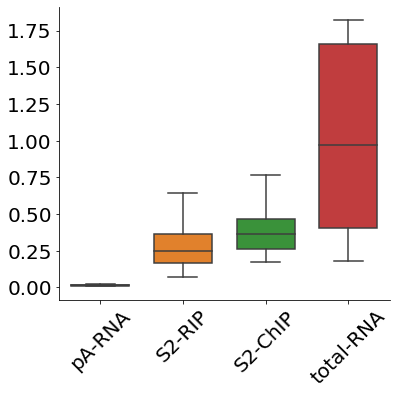

In [35]:
box_plot = sns.catplot(x="seq_type", y="value",
                       hue="seq_category", col="trna_ratio",
                       order=['pA-RNA', 'S2-RIP', 'S2-ChIP', 'total-RNA'],
                       hue_order=['pA-RNA', 'S2-RIP', 'S2-ChIP', 'total-RNA'],
                       data=trna_plot, kind="box",
                       #aspect=1.5,
                       aspect=1.1,
                       dodge = False,
                       #width = 0.3,
                       width = 0.7,
                       legend = False, 
                       #showfliers=True) ## remove outliers
                       showfliers=False) ## remove outliers

box_plot.set_xticklabels(rotation=45, fontsize=20)
box_plot.set_yticklabels(fontsize=20)

#box_plot.set_xlabels('Sequencing Assay', fontsize=35) # not set_label
#box_plot.set_ylabels('tRNA Ratio', fontsize=35)
box_plot.set_xlabels('') # not set_label
box_plot.set_ylabels('')

#box_plot._legend.set_title("Sequencing Assay")
#plt.setp(box_plot._legend.get_texts(), fontsize='22') # for legend text
#plt.setp(box_plot._legend.get_title(), fontsize='32') # for legend title

axes = box_plot.axes.flatten()
axes[0].set_title("")

trna_fig = os.path.join(project_dir, 'results', 'trna_ratios.pdf')
box_plot.savefig(trna_fig)

In [36]:
trna_fig

'/home/pmonteagudo/workspace/silencing_project/results/trna_ratios.pdf'